# Step 0: Import packages!

In [1]:
# For webscraping.
import requests
from bs4 import BeautifulSoup
import re
import random
from time import sleep
from requests_html import HTMLSession

# For standard data manipulation.
import numpy as np
import pandas as pd
from datetime import datetime

# For some quick, adhoc visualizations.
import seaborn as sns
import matplotlib.pyplot as plt

# For handling Geographic estimates.
import geopy
from geopy.exc import GeocoderTimedOut, GeocoderUnavailable
import traceback
from scipy.spatial import distance

# Makes it easier to see all the columns in wide dataframes!
pd.set_option('display.max_colwidth', None)

# Step 1: web scrape AirBnB.

### 1.1: Initiate function that will create the dataframe that will be used to store AirBnB listings.

This will be the DataFrame that catches our scraped data. We'll be getting data like the `title` of the listing, the `rating` of the listing, a list of its `amenities`, the number of `beds` and `bedrooms` -- everything we can easily get off of the listing in AirBnB.

In [2]:
# Make it easy to reset the dataframe while working on this project!
def reset_dataframe():

    # Create the dataframe.
    listings_dataframe = pd.DataFrame(
        {'title': [], 
         'subtitle': [], 
         'superhost': [], 
         'rating': [], 
         'n_ratings': [],
         'price': [],
         'guests': [],
         'bedrooms': [],
         'beds': [],
         'baths': [],
         'amenities': [],
         'n_amenities': [],
         'picture_link': [],
         'listing_link': [],
         'est_lat': [],
         'est_lng': []}
    )
    
    return listings_dataframe

### 1.2 Initiate function that will get the first page of a search results.

This is a simple function that is designed to get the `BeautifulSoup` of a url page. Said another way, we're getting the HTML tree of the webpage.

This function will be fed the first page of the search results, and only the first. You will see how we handle the other pages of the search results soon!

In [3]:
def first_page(url):
    r = requests.get(url)
    text = r.text
    soup = BeautifulSoup(text, 'html.parser')
    return soup

### 1.3: Initiate function that will scrape an AirBnB listing.

Once we have a `BeautifulSoup` representation of the search page's HTML tree, we can take that representation to isolate the information in each individual listing in the `BeautifulSoup` object and pull out all the data fields.

Note: AirBnB's classes shift frequently. While using (or re-using) this scraper might require reviewing  the classes associated with a feature, this approach itself should be fairly resistant to change.

In [4]:
def extract_listing_info(div, df, est_lat, est_lng):
    # Extract all the information about the listing from the search page.
    try:
        # Listing title.
        try:
            title         = div.find_all("span", {"class": "ts5gl90 tl3qa0j t1nzedvd dir dir-ltr"})[0].text
        except:
            title         = None
        # Listing subtitle.
        try:
            subtitle      = div.find_all("div" , {"class": "mj1p6c8 dir dir-ltr"})[0].text
        except:
            subtitle      = None
        # Is it a superhost?
        try:
            if div.find_all("div" , {"class": "t1oq1m17 dir dir-ltr"})[0].text == 'SUPERHOST':
                superhost = 1
        except:
            superhost     = 0
        # Out of 5 stars, what is its rating?
        try:
            rating        = div.find_all("span", {"class": "rpz7y38 dir dir-ltr"})[0].text
        except:
            rating        = None
        # How many reviews has it received?
        try:
            n_ratings     = re.findall('[0-9]+', div.find_all("span", {"class": "r1xr6rtg dir dir-ltr"})[0].text)[0]
        except:
            n_ratings     = None
        # What is the price per night, not including fees?
        try:
            price         = re.findall('[0-9]+', div.find_all("span", {"class": "_tyxjp1"})[0].text)[0]
            #price         = re.findall(r'^[0-9,]*$', div.find_all("span", {"class": "_tyxjp1"})[0].text)[0].replace(",","")
        except:
            price         = None
        # How many guests can the place hold?
        try:
            guests       = re.findall('[0-9]+', div.find_all("span", {"class": "mp2hv9t dir dir-ltr"})[0].text)[0]
        except:
            guests       = None
        # How many bedrooms are there? Some special handling if it is a Studio, handle data to be "0". 
        try:
            if div.find_all("span", {"class": "mp2hv9t dir dir-ltr"})[1].text == 'Studio':
                bedrooms = 0
            else:
                bedrooms = re.findall('[0-9]+', div.find_all("span", {"class": "mp2hv9t dir dir-ltr"})[1].text)[0]
        except:
            bedrooms     = None
         # How many beds are there?   
        try:
            beds         = re.findall('[0-9]+', div.find_all("span", {"class": "mp2hv9t dir dir-ltr"})[2].text)[0]
        except:
            beds         = None
        # How many bathrooms are there?
        try:
            baths        = re.findall('[0-9]+', div.find_all("span", {"class": "mp2hv9t dir dir-ltr"})[3].text)[0]
        except:
            baths        = None
        # What is the list of amenities associated with the place?
        try:
            amenities    = [amenity.text for amenity in div.find_all("span", {"class": "mp2hv9t dir dir-ltr"})[4:]]
        except:
            amenities    = None
        # What is the main picture for the listing?
        try:
            picture_link = div.find("div", {"class": "_4626ulj"}).picture.find('img')['src']
        except:
            picture_link = None
        # What is the page for the listing itself?
        try:
            
            listing_link = 'https://www.airbnb.com' + div.find("a", {"class": "l8au1ct dir dir-ltr"})['href']
        except:
            listing_link = None
        # How many amenities are listed?
        try:
            n_amenities  = len(amenities)
        except:
            n_amenities  = None
        
        # Create a single row dataframe with the results.
        row = pd.DataFrame(
            {'title': title, 
             'subtitle': subtitle, 
             'superhost': superhost, 
             'rating': rating, 
             'n_ratings': n_ratings,
             'price': price,
             'guests': guests,
             'bedrooms': bedrooms,
             'beds': beds,
             'baths': baths,
             'amenities': [amenities],
             'n_amenities': n_amenities,
             'picture_link': picture_link,
             'listing_link': listing_link,
             'est_lat': est_lat,
             'est_lng': est_lng
            }
        )
        
        # Return dataframe, with new row of data appended.
        return pd.concat([df, row], ignore_index=True)
    
    except:     
        # If listing can't be scraped, return dataframe as is.
        return df
    

### 1.4: Initiate function that will move onto the next page of search results when it is done with a page.

Above, we created a function that fed the webscraper the first page of the search results. This function takes the webpage and, once we've scraped all the listings, looks to see if there is another page of results. If there is another page of results, it fetches the `BeautifulSoup` object for that next page. If not, it returns nothing.

In [5]:
def get_next_page(soup):

    try:
        url = 'https://www.airbnb.com' + soup.find('a',{"class":"_1bfat5l"})['href']
        r = requests.get(url)                                                # Request the HTML.
        text = r.text                                                        # Extract the text.
        soup = BeautifulSoup(text, 'html.parser')                            # Soupify text.
        return soup
    except:
        return None
        

### 1.5: Generate 45,000~ geographic snapshots of Colorado.

Here is where we get creative! AirBnB doesn't list the the exact location of its listings. While their reason for doing this is sensible, we need to get that information.

So, what we'll do is use the northernmost and southernest most latitudes in Colorado, as well as the westernmost and easternmost longitude, and slice this rectangle into 45,000 small boxes. In each box, we'll get the latitude and longitude corners for each box. AirBnB can take these corners as parameters in the search URL to return only Colorado listings that are inside this box.

While this doesn't give us the _exact_ location of the listing, it allows for us to programmatically scrape and store an estimate that is within 1~ mile of being correct.

When we generate the map views, we save the estimated lat/lng at the center of the box in a dictionary with the url so it can be referenced easily by the webscraper as it aggregates data.

In [6]:
def generate_mapviews():
    
    # Colorado borders.
    north_lat =   41.00000
    south_lat =   36.99250
    east_lng  = -102.04570
    west_lng  = -109.05170
    
    coords = []
    
    # incrementing between western and easternmost longitude, in .01 increments:
    for lng in np.arange(west_lng, east_lng,.025):      
        # incrementing between southern and northernmost latitude, in .01 increments:
        for lat in np.arange(south_lat, north_lat,.025):
            # Create a dictionary to define the 
            coord = {
                'ne_lat':lat+.025,
                'ne_lng':lng+.025,
                'sw_lat':lat,
                'sw_lng':lng
            }
            
            coords.append(coord)
            
    def gen_links(coord):
        
        return ('https://www.airbnb.com/s/',
                'Colorado--United-States/homes?',
                'search_type=user_map_move',
                '&ne_lat={}'.format(coord['ne_lat']),
                '&ne_lng={}'.format(coord['ne_lng']),
                '&sw_lat={}'.format(coord['sw_lat']),
                '&sw_lng={}'.format(coord['sw_lng']))
    
    # Store the URL, as long as the estimated lat/long location -- average of the northern/southern most lat,
    # and the eastern/western most long in the view.
    coord_data = []
    
    for coord in coords:
        dict_ = {
            'url': ''.join(gen_links(coord)),
            'est_lat':(coord['ne_lat']+coord['sw_lat'])/2,
            'est_lng':(coord['ne_lng']+coord['sw_lng'])/2
        }
        
        coord_data.append(dict_)
    
    return coord_data

urls = generate_mapviews()

print('Sample output of URLs:')
urls[:2]

Sample output of URLs:


[{'url': 'https://www.airbnb.com/s/Colorado--United-States/homes?search_type=user_map_move&ne_lat=37.0175&ne_lng=-109.02669999999999&sw_lat=36.9925&sw_lng=-109.0517',
  'est_lat': 37.004999999999995,
  'est_lng': -109.0392},
 {'url': 'https://www.airbnb.com/s/Colorado--United-States/homes?search_type=user_map_move&ne_lat=37.0425&ne_lng=-109.02669999999999&sw_lat=37.0175&sw_lng=-109.0517',
  'est_lat': 37.03,
  'est_lng': -109.0392}]

### 1.6: Scrape 30,000~ Colorado AirBnB listings!

In [7]:
# Change to 'if True' to run. Warning! It takes 2.5 days!
# Unless there is a specific reason to do so, just read it in
# from the backup CSV that already saved the results.
if False:
    # Reset the dataframe.
    listings_dataframe = reset_dataframe()
    
    # A pretty print message to let me know when the scraping started.
    print('Start scraping: {}'.format(datetime.now()))
    
    # Keeping track of the number of URLs that have been worked through.
    url_count = 0
    
    # Generate all of the urls.
    urls = generate_mapviews()
    
    # For each url:
    for url in urls:
        
        # Feed the url through to get the soup of the first page.
        soup = first_page(url['url'])
        
        # Until the scraper cannot find another page to scrape.
        while soup != None:
            
            # Get all of the individual listings on the page.
            mydivs = soup.find_all("div", {"class": "cm4lcvy dir dir-ltr"})
            
            # for each listing.
            for div in mydivs:
                
                # Append the scraped data to page. Note that we feed
                # the lat/long from the url.
                listings_dataframe = extract_listing_info(
                    div=div,
                    df=listings_dataframe,
                    est_lat=url['est_lat'],
                    est_lng=url['est_lng'])
                
            # Sleep for 1-6 seconds. Just in case someone is monitoring
            # my events on AirBnB's side, I want to give at least *some*
            # illusion that this is a human being and not a scraper.
            sleep(random.randint(1,3))
            
            # Attempt to go to next page. If no next page is found, returns
            # None and breaks the loop. This completes the loop for one url,
            # and the scraper moves onto the next url.
            soup = get_next_page(soup=soup)
        
        # Tick another url completed.
        url_count += 1
        
        # For every 1,000 urls completed, print out a status message of progress.
        if url_count % 1000 == 0:
            print('- {} urls out of {} scraped: {}'.format(url_count, len(urls), datetime.now()))
    
    # A pretty print message. You are all done!
    print('Done. {} listings scraped: {}'.format(len(listings_dataframe), datetime.now()))
    
    # Get length of dataset.
    predupe = len(listings_dataframe)

    # We assume with this method their might be some duplicate scrapes. This method will
    # drop the duplicates, and keep the first occurrence.
    subset_cols = ['title','subtitle','picture_link']
    listings_dataframe = listings_dataframe.drop_duplicates(subset=subset_cols, keep='first')
    postdupe = len(listings_dataframe)
    delta = predupe - postdupe
    
    # Pretty print the results post de-duplication.
    print(f'''
    After deduplication, the AirBnB listings dataset decreased from {predupe} to {postdupe}, a decrease of
    {delta}. Where duplicates were found, the first record was taken.
    ''')
    
    # Save the results.
    listings_dataframe.to_csv('listings_dataframe.csv')

# Just read in the already scraped data!
if True:
    listings_dataframe = pd.read_csv('listings_dataframe_BACKUP.csv')
    listings_dataframe.drop(columns=['Unnamed: 0'],inplace=True)
    print('Done. Read in listings from backup file of the original scraping.')

Done. Read in listings from backup file of the original scraping.


In [8]:
# Peak at the output.
listings_dataframe.head()

,title,subtitle,superhost,rating,n_ratings,price,guests,bedrooms,beds,baths,amenities,n_amenities,picture_link,listing_link,est_lat,est_lng
0,"Dog paradise, ATVs, hikes,canyons, eggs,420, fruit",Farm stay in Paradox,1.0,4.95,42.0,228,12,2,2.0,1.0,"['Wifi', 'Kitchen', 'Indoor fireplace', 'Free parking']",4.0,https://a0.muscache.com/im/pictures/a854c2ba-9585-4c61-b582-9340b37152b2.jpg?im_w=720,https://www.airbnb.com/rooms/44060617?previous_page_section_name=1000&federated_search_id=c2c2752f-0e51-4242-8ab0-d20b963ae720,38.305,-109.0142
1,Cozy & Quiet 3 bedroom Mountain Cabin Retreat.,Entire cabin in Glade Park,0.0,NaN,NaN,157,8,3,4.0,2.0,"['Wifi', 'Kitchen', 'Indoor fireplace', 'Free parking']",4.0,https://a0.muscache.com/im/pictures/miso/Hosting-591194037920951691/original/3c62ae9c-155a-45a1-9274-8738f2c21e15.jpeg?im_w=720,https://www.airbnb.com/rooms/591194037920951691?previous_page_section_name=1000&federated_search_id=ac5a921b-d2b2-4147-b6ac-db15daea1077,38.955,-109.0142
2,Palisade Tent at Gateway Glamping,Tent in Gateway,1.0,5.00,10.0,125,2,1,1.0,1.0,"['Kitchen', 'Free parking']",2.0,https://a0.muscache.com/im/pictures/18691dd9-84ff-421a-8b21-dbe1c13ae051.jpg?im_w=720,https://www.airbnb.com/rooms/48296711?previous_page_section_name=1000&federated_search_id=ca4f224d-314b-4c2b-956d-1ed9b026602c,38.680,-108.9892
3,The Escalante Tent at Gateway Glamping,Tent in Gateway,1.0,NaN,NaN,125,2,1,1.0,1.0,"['Kitchen', 'Free parking']",2.0,https://a0.muscache.com/im/pictures/27cef231-6a5d-47ff-9b4d-7ad47d98fd39.jpg?im_w=720,https://www.airbnb.com/rooms/52169821?previous_page_section_name=1000&federated_search_id=ca4f224d-314b-4c2b-956d-1ed9b026602c,38.680,-108.9892
4,Desert Glamping on the Delores River!,Camper/RV in Gateway,0.0,NaN,NaN,85,2,1,1.0,0.0,"['Kitchen', 'Free parking']",2.0,https://a0.muscache.com/im/pictures/d58d96af-4e4d-4689-8245-4f5cb622f462.jpg?im_w=720,https://www.airbnb.com/rooms/53459603?previous_page_section_name=1000&federated_search_id=0f54051a-1ff8-4162-a573-bf5f7c312972,38.655,-108.9642


### 1.8: Visually check the listings data.

Let's do a quick visual check of the results that were scraped against our expectation. Looking at the visual below, the density of listings we are getting is matching the areas of the map we'd expect them to be in -- the major Colorado cities and ski towns have the highest density of listings. 

At a high-level, it looks like we have this AirBnB data scraped!

In [9]:
# Group the number of listings in each of the 45,000 boxes we generated for Colorado.
group = listings_dataframe[['est_lat','est_lng']].groupby(['est_lat','est_lng']).size().reset_index()
group.columns = ['est_lat','est_lng','n_listings']
group.head()

,est_lat,est_lng,n_listings
0,37.005,-107.8892,3
1,37.005,-107.4642,2
2,37.005,-107.4142,1
3,37.005,-107.1142,5
4,37.005,-103.8892,1


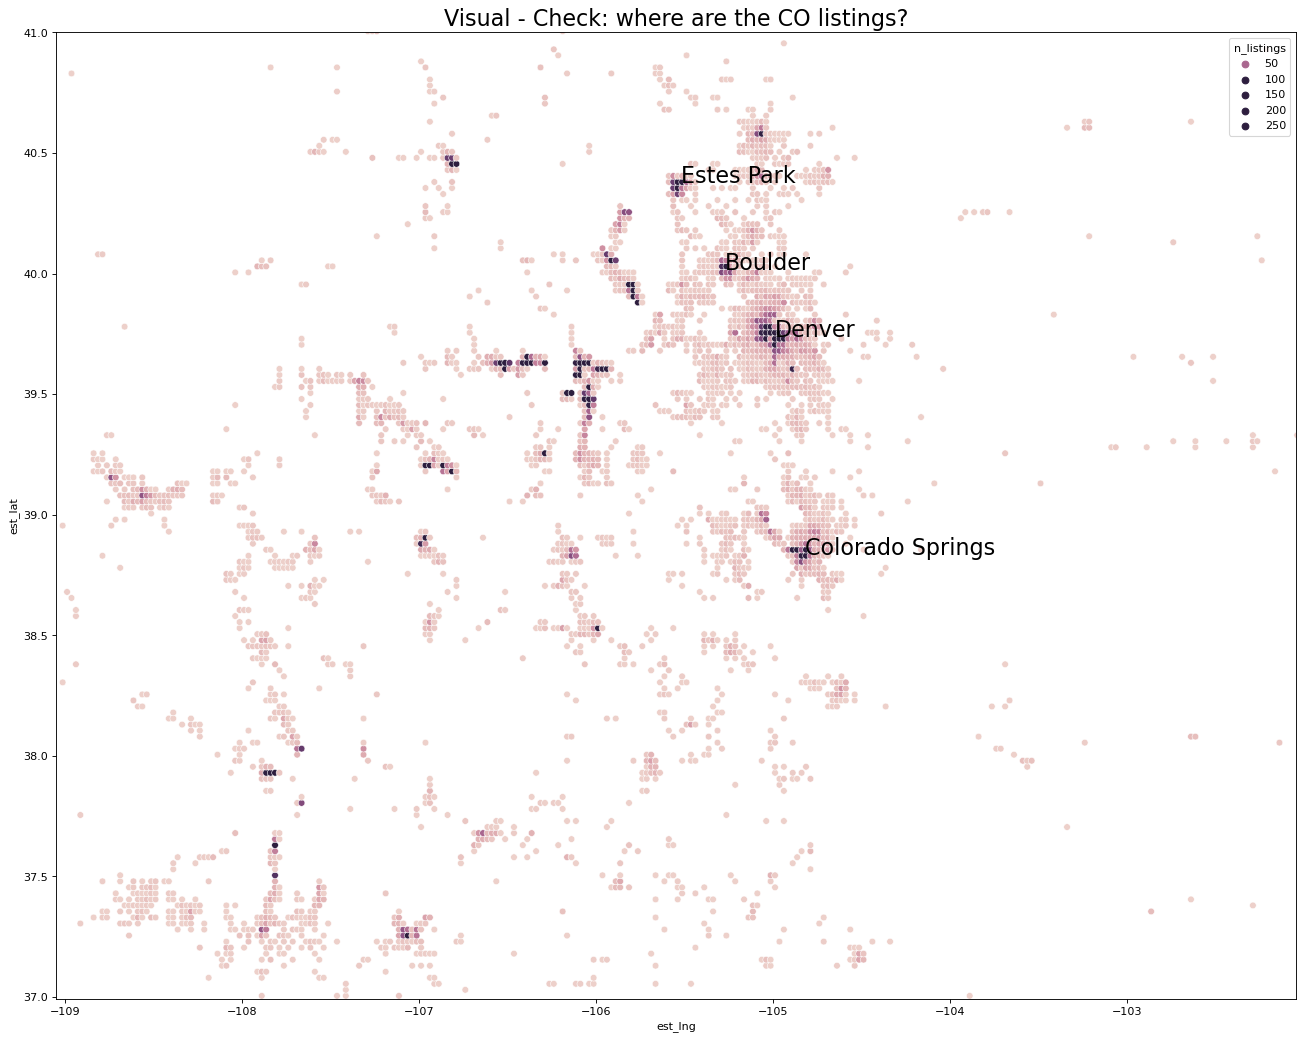

In [10]:
#listings_dataframe['price'] = listings_dataframe['price'].astype('int')

# Create the figure.
plt.figure(figsize=(20, 16), dpi=80)

# Create the scatterplot.
sns.scatterplot(data=group, x='est_lng', y='est_lat',hue='n_listings',hue_norm=(0,100))

# Limit size to the boundaries of Colorado.
plt.xlim([-109.05170,-102.04570])
plt.ylim([36.99250,41])

# Draw on a few cities of interest to gut check results are showing up in the right area.
plt.text(-104.9903,39.7392,'Denver',size=20)
plt.text(-104.8214,38.8339,'Colorado Springs',size=20)
plt.text(-105.2705,40.0150,'Boulder',size=20)
plt.text(-105.5217,40.3772,'Estes Park',size=20)

# Figure title.
plt.title('Visual - Check: where are the CO listings?',size=20)

# Show figure.
plt.show()


# Step 2: Scrape UnitedStatesZipcodes.org

### 2.1: Create a list of all 511 Colorado zip codes.

To get the data we need for each zipcode, we'll need a list of each of the 511 zipcodes in Colorado. Let's generate that now.

In [11]:
# Colorado zipcodes.
zipcodes = [
    '80013', '80219', '80015', '80134', '80634', '80016', '80525', '80631',
    '80229', '80504', '80012', '80011', '80022', '80020', '80233', '80538', '80918',
    '80239', '80123', '80526', '80127', '80537', '80126', '80010', '80401', '80221',
    '80501', '80916', '80601', '80920', '80014', '80909', '80017', '80906', '80210',
    '80231', '80521', '80004', '80524', '80220', '80003', '80128', '80602', '80911',
    '80031', '80211', '80503', '80205', '80227', '80260', '80228', '80021', '80112',
    '80204', '80027', '80241', '80226', '80138', '80111', '80122', '80249', '81005',
    '80120', '81007', '80104', '80910', '80129', '80917', '81212', '81301', '80026',
    '80817', '80550', '81001', '80922', '81504', '80907', '80302', '80130', '80005',
    '80516', '80234', '80919', '80214', '80207', '81004', '80304', '80033', '80301',
    '80831', '80209', '80303', '80206', '80439', '80921', '81501', '80222', '80110',
    '80232', '80528', '81401', '80237', '80238', '80915', '80203', '80132', '80124',
    '80403', '80904', '80223', '80620', '80212', '80215', '80218', '80236', '80121',
    '80224', '80002', '80908', '80751', '80487', '81623', '80305', '80534', '81521',
    '80903', '80905', '80465', '80030', '80701', '81503', '81601', '80202', '81101',
    '81321', '81003', '81416', '81520', '80603', '81650', '80007', '80216', '80107',
    '80246', '80018', '80863', '80640', '80513', '80621', '81625', '81147', '80925',
    '81506', '80549', '81006', '81008', '81082', '81611', '81620', '80125', '81505',
    '80517', '80424', '81230', '80421', '80230', '81201', '81050', '81632', '81226',
    '81052', '81631', '80235', '81122', '80433', '81637', '80615', '81211', '81303',
    '80498', '80435', '80461', '80543', '80310', '81647', '80723', '81144', '81635',
    '80840', '80118', '80816', '80829', '81137', '80808', '80106', '81657', '80102',
    '81425', '81621', '81067', '80514', '80136', '80642', '81526', '81413', '81435',
    '80645', '81652', '80542', '81054', '80422', '80530', '80759', '80540', '80807',
    '81323', '80443', '81089', '81328', '80116', '80651', '80446', '80135', '81252',
    '80643', '80913', '81641', '81419', '80758', '80828', '80814', '80466', '81240',
    '80470', '81125', '80610', '81132', '81428', '81224', '80452', '81063', '80644',
    '80734', '81432', '80103', '80459', '80117', '81615', '80019', '80720', '81639',
    '81648', '80654', '80535', '80547', '80133', '80440', '80447', '81326', '81120',
    '80442', '81140', '80467', '81069', '80930', '80137', '81151', '80536', '81073',
    '81418', '81527', '81423', '81524', '80737', '81019', '81039', '80520', '80926',
    '81022', '81062', '81055', '80512', '81334', '80650', '81410', '80648', '80864',
    '81654', '81047', '81225', '80813', '80454', '81624', '81023', '81131', '80478',
    '81152', '81525', '81324', '81141', '80705', '81236', '80928', '81223', '80810',
    '81415', '80731', '80480', '80105', '80611', '80836', '80444', '80743', '80624',
    '81427', '80809', '81645', '80821', '81036', '80728', '81630', '81133', '81424',
    '80451', '81123', '81154', '81233', '81058', '80835', '80515', '80545', '80623',
    '81090', '81523', '81020', '80045', '80741', '80820', '81092', '80482', '81430',
    '80449', '81149', '81041', '80420', '81235', '81146', '80815', '80819', '81143',
    '81077', '80653', '81130', '81025', '80832', '81076', '80427', '80483', '80827',
    '81091', '80833', '80729', '80428', '81422', '81231', '80456', '81253', '80436',
    '80652', '81059', '80860', '81433', '80727', '80726', '80736', '80733', '80101',
    '80438', '81242', '80825', '80914', '80805', '80481', '80735', '80722', '81327',
    '81643', '80818', '80744', '80468', '80455', '81057', '81244', '81222', '80469',
    '80131', '81431', '80649', '80747', '81649', '80497', '81121', '81331', '80612',
    '81029', '81071', '80488', '81044', '81210', '81221', '81148', '81040', '80025',
    '80861', '80510', '80804', '80834', '81064', '81434', '80802', '81610', '80721',
    '81320', '80750', '80423', '80812', '80745', '80822', '81049', '81646', '80749',
    '80546', '81024', '81155', '81656', '80024', '81136', '80742', '81332', '80824',
    '80823', '81033', '80757', '80457', '80754', '80830', '80432', '81251', '80622',
    '81027', '80476', '81124', '81426', '81030', '80463', '80425', '81220', '80511',
    '81126', '81325', '80801', '81087', '81640', '81522', '80532', '80544', '81128',
    '81241', '80453', '80740', '81084', '80755', '80929', '81248', '81239', '80477',
    '81655', '81081', '80746', '81243', '81638', '81129', '81330', '81045', '81043',
    '80862', '81429', '81335', '81138', '81021', '80434', '81411', '80426', '81237',
    '81232', '81642', '81653', '80473', '80479', '80419', '80448', '80294', '81633',
    '80293', '81227', '80290', '81612', '81038', '80264', '80475', '80471']

### 2.2 Initiate function that creates a UnitedStaesZipCodes.org link for each zip code.

A simple function for generating the links to each zipcode. It's fairly straightforward: all the links will be structured as `https://www.unitedstateszipcodes.org/` + `zipcode`.

In [12]:
def generate_zipcode_links(zipcode):
    return 'https://www.unitedstateszipcodes.org/' + zipcode

### 2.3 Initiate function that will create the dataframe to store zip code data.

This will catch and store the data we get during the web scraping process. We'll store the zipcode, and information about that zipcode such as the `population`, attributes on the population such as `race`, attributes on the housing such as vaccancies and ownership, and more.

In [13]:
# Make it easy to reset the dataframe while working on this project!
def reset_zipcode_dataframe():

    # Create the dataframe.
    zipcodes_dataframe = pd.DataFrame(
        {
        'zipcode':[],
        'population':[],
        'pop_density_sq_mile':[],
        'housing_units':[],
        'median_home_price':[],
        'land_area_sq_mile':[],
        'water_area_sq_mile':[],
        'occupied_housing_units':[],
        'median_household_income':[],
        'median_age':[],
        'race_per_white':[],
        'race_per_black_or_aframr':[],
        'race_per_native_american':[],
        'race_per_asian':[],
        'race_per_pacific_islander':[],
        'race_per_other':[],
        'race_per_two_or_more':[],
        'housing_per_owned_w_mortgage':[],
        'housing_per_owned_free_clear':[],
        'housing_per_renter_occupied':[],
        'housing_per_vacant':[],
        'vacant_per_for_rent':[],
        'vacant_per_rented_unoccupied':[],
        'vacant_per_for_sale':[],
        'vacant_per_sold_unoccupied':[],
        'vacant_per_seasonal_recreational':[],
        'vacant_per_migrant_workers':[],
        'vacant_per_others':[],
        'edu_per_less_than_hs':[],
        'edu_per_hs':[],
        'edu_per_associates':[],
        'edu_per_bachelors':[],
        'edu_per_masters':[],
        'edu_per_professional':[],
        'edu_per_phd':[],
        'child_edu_per_enrolled_public':[],
        'child_edu_per_enrolled_private':[],
        'child_edu_per_not_enrolled':[]}
    )
    
    return zipcodes_dataframe

### 2.4: Initiate the function that will get the results on the zip code's page.

Create a function that gets the `BeautifulSoup` object for the zipcode webpage given to it. Because this webpage has a few more defenses to webscraping, I need to add a few other features like adding headers to the request to make it look more human, and keep the web scraping open if I hit a daily limit, checking once per hour until the daily limit resets.

In [14]:
def zipcode_soup(url):
    count = 0
    while True:
        headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
        r = requests.get(url,headers=headers,timeout=10)
        text = r.text
        if """You have reached your limit for the day""" in text:
            print("{} out of 511 links scraped.".format(count))
            print('Hit daily limit. Powering down, will try again in 12 hours...{}'.format(datetime.now()))
            sleep(60*60*12)
        else:
            count += 1
            break
    soup = BeautifulSoup(text, 'html.parser')  
    return soup

### 2.5 Initiate the function that will scrape all of the data about that zipcode.

Initiate function that will scrape all of the information out of a `BeautifulSoup` object for the webpage.

In [15]:
def scrape_zipcodes(soup, df):
    try:
        try:
            zipcode = re.findall('[0-9]+', soup.find_all("div", {"class": "col-xs-12 col-md-5 col-lg-4"})[0].find_all("h1")[0].text)[0]
        except:
            zipcode = None
        try:
            population = soup.find_all("div", {"class": "col-xs-12 col-sm-6"})[0].find_all("td", {"class":"text-right"})[0].text
        except:
            population = None
        try:
            pop_density = soup.find_all("div", {"class": "col-xs-12 col-sm-6"})[0].find_all("td", {"class":"text-right"})[1].text
        except:
            pop_density = None
        try:
            housing_units = soup.find_all("div", {"class": "col-xs-12 col-sm-6"})[0].find_all("td", {"class":"text-right"})[2].text
        except:
            housing_units = None
        try:
            median_house_price = soup.find_all("div", {"class": "col-xs-12 col-sm-6"})[0].find_all("td", {"class":"text-right"})[3].text
        except:
            median_house_price = None
        try:
            land_sq_mile = soup.find_all("div", {"class": "col-xs-12 col-sm-6"})[1].find_all("td", {"class":"text-right"})[0].text
        except:
            land_sq_mile = None
        try:
            water_sq_mile = soup.find_all("div", {"class": "col-xs-12 col-sm-6"})[1].find_all("td", {"class":"text-right"})[1].text
        except:
            water_sq_mile = None
        try:
            occupied_housing_units = soup.find_all("div", {"class": "col-xs-12 col-sm-6"})[1].find_all("td", {"class":"text-right"})[2].text
        except:
            occupied_housing_units = None
        try:
            median_household_income = soup.find_all("div", {"class": "col-xs-12 col-sm-6"})[1].find_all("td", {"class":"text-right"})[3].text
        except:
            median_household_income = None
        try:
            median_age = soup.find_all("div",{"class":"well well-sm chart-section"})[1].find_all("td")[1].text
        except:
            median_age = None
        try:
            percent_white = soup.find_all("div",{"class":"col-xs-12 col-sm-8"})[2].find_all("td",{"class":"text-right"})[1].text
        except:
            percent_white = None
        try:
            percent_black = soup.find_all("div",{"class":"col-xs-12 col-sm-8"})[2].find_all("td",{"class":"text-right"})[3].text
        except:
            percent_black = None
        try:
            percent_native_american = soup.find_all("div",{"class":"col-xs-12 col-sm-8"})[2].find_all("td",{"class":"text-right"})[5].text
        except:
            percent_native_american = None
        try:
            percent_asian = soup.find_all("div",{"class":"col-xs-12 col-sm-8"})[2].find_all("td",{"class":"text-right"})[7].text
        except:
            percent_asian = None
        try:
            percent_pacific_islander = soup.find_all("div",{"class":"col-xs-12 col-sm-8"})[2].find_all("td",{"class":"text-right"})[9].text
        except:
            percent_pacific_islander = None
        try:
            percent_other = soup.find_all("div",{"class":"col-xs-12 col-sm-8"})[2].find_all("td",{"class":"text-right"})[11].text
        except:
            percent_other = None
        try:
            percent_two_or_more = soup.find_all("div",{"class":"col-xs-12 col-sm-8"})[2].find_all("td",{"class":"text-right"})[13].text
        except:
            percent_two_or_more = None
        try:
            owned_w_mortgage = soup.find_all("div",{"class":"col-xs-12 col-sm-8"})[6].find_all("td",{"class":"text-right"})[1].text
        except:
            owned_w_mortgage = None
        try:
            owned_free_clear = soup.find_all("div",{"class":"col-xs-12 col-sm-8"})[6].find_all("td",{"class":"text-right"})[3].text
        except:
            owned_free_clear = None
        try:
            renter_occupied = soup.find_all("div",{"class":"col-xs-12 col-sm-8"})[6].find_all("td",{"class":"text-right"})[5].text
        except:
            renter_occupied = None
        try:
            vacant = soup.find_all("div",{"class":"col-xs-12 col-sm-8"})[6].find_all("td",{"class":"text-right"})[7].text
        except:
            vacant = None
        try:
            for_rent = soup.find_all("div",{"class":"col-xs-12 col-sm-8"})[7].find_all("td",{"class":"text-right"})[1].text
        except:
            for_rent = None
        try:
            rented_unoccupied = soup.find_all("div",{"class":"col-xs-12 col-sm-8"})[7].find_all("td",{"class":"text-right"})[3].text
        except:
            rented_unoccupied = None
        try:
            for_sale = soup.find_all("div",{"class":"col-xs-12 col-sm-8"})[7].find_all("td",{"class":"text-right"})[5].text
        except:
            for_sale = None
        try:
            sold_unoccupied = soup.find_all("div",{"class":"col-xs-12 col-sm-8"})[7].find_all("td",{"class":"text-right"})[7].text
        except:
            sold_unoccupied = None
        try:
            seasonal_recreational = soup.find_all("div",{"class":"col-xs-12 col-sm-8"})[7].find_all("td",{"class":"text-right"})[9].text
        except:
            seasonal_recreational = None
        try:
            migrant_workers = soup.find_all("div",{"class":"col-xs-12 col-sm-8"})[7].find_all("td",{"class":"text-right"})[11].text
        except:
            migrant_workers = None
        try:
            other_reasons = soup.find_all("div",{"class":"col-xs-12 col-sm-8"})[7].find_all("td",{"class":"text-right"})[13].text
        except:
            other_reasons = None
        try:
            less_than_hs = soup.find_all("div",{"class":"col-xs-12 col-sm-8"})[12].find_all("td",{"class":"text-right"})[1].text
        except:
            less_than_hs = None
        try:
            hs_grad = soup.find_all("div",{"class":"col-xs-12 col-sm-8"})[12].find_all("td",{"class":"text-right"})[3].text
        except:
            hs_grad = None
        try:
            associates = soup.find_all("div",{"class":"col-xs-12 col-sm-8"})[12].find_all("td",{"class":"text-right"})[5].text
        except:
            associates = None
        try:
            bachelors = soup.find_all("div",{"class":"col-xs-12 col-sm-8"})[12].find_all("td",{"class":"text-right"})[7].text
        except:
            bachelors = None
        try:
            masters = soup.find_all("div",{"class":"col-xs-12 col-sm-8"})[12].find_all("td",{"class":"text-right"})[9].text
        except:
            masters = None
        try:
            professional = soup.find_all("div",{"class":"col-xs-12 col-sm-8"})[12].find_all("td",{"class":"text-right"})[11].text
        except:
            professional = None
        try:
            phd = soup.find_all("div",{"class":"col-xs-12 col-sm-8"})[12].find_all("td",{"class":"text-right"})[13].text
        except:
            phd = None
        try:
            enrolled_public = soup.find_all("div",{"class":"col-xs-12 col-sm-8"})[13].find_all("td",{"class":"text-right"})[1].text
        except:
            enrolled_public = None
        try:
            enrolled_private = soup.find_all("div",{"class":"col-xs-12 col-sm-8"})[13].find_all("td",{"class":"text-right"})[3].text
        except:
            enrolled_private = None
        try:
            not_enrolled = soup.find_all("div",{"class":"col-xs-12 col-sm-8"})[13].find_all("td",{"class":"text-right"})[5].text
        except:
            not_enrolled = None
        
        row = pd.DataFrame(
        {
        'zipcode':                          [zipcode],
        'population':                       [population],
        'pop_density_sq_mile':              [pop_density],
        'housing_units':                    [housing_units],
        'median_home_price':                [median_house_price],
        'land_area_sq_mile':                [land_sq_mile],
        'water_area_sq_mile':               [water_sq_mile],
        'occupied_housing_units':           [occupied_housing_units],
        'median_household_income':          [median_household_income],
        'median_age':                       [median_age],
        'race_per_white':                   [percent_white],
        'race_per_black_or_aframr':         [percent_black],
        'race_per_native_american':         [percent_native_american],
        'race_per_asian':                   [percent_asian],
        'race_per_pacific_islander':        [percent_pacific_islander],
        'race_per_other':                   [percent_other],
        'race_per_two_or_more':             [percent_two_or_more],
        'housing_per_owned_w_mortgage':     [owned_w_mortgage],
        'housing_per_owned_free_clear':     [owned_free_clear],
        'housing_per_renter_occupied':      [renter_occupied],
        'housing_per_vacant':               [vacant],
        'vacant_per_for_rent':              [for_rent],
        'vacant_per_rented_unoccupied':     [rented_unoccupied],
        'vacant_per_for_sale':              [for_sale],
        'vacant_per_sold_unoccupied':       [sold_unoccupied],
        'vacant_per_seasonal_recreational': [seasonal_recreational],
        'vacant_per_migrant_workers':       [migrant_workers],
        'vacant_per_others':                [other_reasons],
        'edu_per_less_than_hs':             [less_than_hs],
        'edu_per_hs':                       [hs_grad],
        'edu_per_associates':               [associates],
        'edu_per_bachelors':                [bachelors],
        'edu_per_masters':                  [masters],
        'edu_per_professional':             [professional],
        'edu_per_phd':                      [phd],
        'child_edu_per_enrolled_public':    [enrolled_public],
        'child_edu_per_enrolled_private':   [enrolled_private],
        'child_edu_per_not_enrolled':       [not_enrolled]}
    )

        # Return dataframe, with new row of data appended.
        return pd.concat([df, row], ignore_index=True)
    
    except:  
        # If zipcode can't be scraped, return dataframe as is.
        return df

### 2.6: Get zip code data for each of the 511 zipcodes in Colorado.

In [16]:
print('Starting scrape...{}'.format(datetime.now()))

# Turn on to True if you want to test running the scraper! This should take <5 minutes to run,
# unless you hit a daily limit. In which case, the operation will hang open for 12 hours, try again,
# and repeat this operation until it has all the data..
if False:
    # Get zipode links.
    zipcode_links = [generate_zipcode_links(zipcode) for zipcode in zipcodes]

    # Reset the dataframe.
    zipcodes_dataframe = reset_zipcode_dataframe()

    # For each link, get the beautiful soup, and scrape it for data.
    count = 0
    for link in zipcode_links:
        soup = zipcode_soup(url=link)
        zipcodes_dataframe = scrape_zipcodes(soup=soup, df=zipcodes_dataframe)
        count += 1
        # Pretty print out progress on the backfill.
        if count % 100 == 0:
            print(f'''{count} zipcodes scraped ({datetime.now()})''')

    # Check output.
    print('{} Colorado zipcodes scraped (expected: 511).'.format(len(zipcodes_dataframe)))
    
    #print('Checking for null values that didn\'t get scraped...')
    
    zipcodes_dataframe = zipcodes_dataframe.dropna(how='all')
    
    if len(zipcodes_dataframe) < 511:
        while True:
            print(f'''{len(zipcodes_dataframe)} zipcodes scraped. Attempting to rescraped the missed ones ({datetime.now()})''')
        
            finished_zipcodes = zipcodes_dataframe['zipcode'].tolist()
            zipcode_links = [generate_zipcode_links(zipcode) for zipcode in zipcodes if zipcode not in finished_zipcodes]
            
            count = 0
            for link in zipcode_links:
                soup = zipcode_soup(url=link)
                zipcodes_dataframe = scrape_zipcodes(soup=soup, df=zipcodes_dataframe)
                count += 1
                # Pretty print out progress on the backfill.
                if count % 100 == 0:
                    print(f'''{count} zipcodes scraped ({datetime.now()})''')
            print('{} Colorado zipcodes scraped (expected: 511).'.format(len(zipcodes_dataframe)))
            zipcodes_dataframe = zipcodes_dataframe.dropna(how='all')
            if len(zipcodes_dataframe) < 511:
                continue
            else:
                break
                      
          
    
    # Save locally as CSV.
    zipcodes_dataframe.to_csv('zipcodes_dataframe_BACKUP.csv')

# To make it simple, just read in the back up file!
if True:
    # Add file read in method, so you only have to scrape once!
    zipcodes_dataframe = pd.read_csv('zipcodes_dataframe_BACKUP.csv')
    zipcodes_dataframe.drop(columns=['Unnamed: 0'],inplace=True)
    print('Done. Read in listings from backup file of the original scraping.')

Starting scrape...2022-05-23 14:54:18.002325
Done. Read in listings from backup file of the original scraping.


In [17]:
zipcodes_dataframe.head()

,zipcode,population,pop_density_sq_mile,housing_units,median_home_price,land_area_sq_mile,water_area_sq_mile,occupied_housing_units,median_household_income,median_age,...,edu_per_less_than_hs,edu_per_hs,edu_per_associates,edu_per_bachelors,edu_per_masters,edu_per_professional,edu_per_phd,child_edu_per_enrolled_public,child_edu_per_enrolled_private,child_edu_per_not_enrolled
0,80013,"69,588","4,975","26,047","$192,800",13.99,0.00,"24,791","$67,857",34.0,...,8.0&percnt,51.0&percnt,12.1&percnt,20.5&percnt,6.9&percnt,0.9&percnt,0.5&percnt,82.0&percnt,7.8&percnt,10.2&percnt
1,80219,"61,296","8,166","20,448","$151,000",7.51,0.07,"19,171","$39,659",30.0,...,36.5&percnt,48.0&percnt,4.8&percnt,7.9&percnt,2.2&percnt,0.4&percnt,0.2&percnt,83.9&percnt,2.1&percnt,14.0&percnt
2,80015,"62,432","4,367","21,996","$241,500",14.30,0.23,"21,240","$80,599",35.0,...,5&percnt,43&percnt,10&percnt,27&percnt,11&percnt,2&percnt,1&percnt,85.7&percnt,8.6&percnt,5.7&percnt
3,80134,"55,075",977,"20,452","$310,200",56.35,0.08,"19,555","$100,739",35.0,...,2&percnt,35&percnt,9&percnt,39&percnt,12&percnt,2&percnt,1&percnt,80.0&percnt,13.4&percnt,6.6&percnt
4,80634,"52,861","1,418","21,776","$184,900",37.28,0.09,"20,456","$58,959",36.0,...,10&percnt,50&percnt,9&percnt,20&percnt,7&percnt,1&percnt,2&percnt,77.9&percnt,11.9&percnt,10.3&percnt


In [18]:
zipcodes_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 511 entries, 0 to 510
Data columns (total 38 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   zipcode                           511 non-null    int64  
 1   population                        511 non-null    object 
 2   pop_density_sq_mile               506 non-null    object 
 3   housing_units                     511 non-null    object 
 4   median_home_price                 477 non-null    object 
 5   land_area_sq_mile                 511 non-null    object 
 6   water_area_sq_mile                511 non-null    float64
 7   occupied_housing_units            511 non-null    object 
 8   median_household_income           483 non-null    object 
 9   median_age                        506 non-null    float64
 10  race_per_white                    507 non-null    object 
 11  race_per_black_or_aframr          507 non-null    object 
 12  race_per

### 2.7: Clean data in zipcode dataset

In [19]:
def convert_percent(x):
    if x != None:
        return float(str(x).replace("&percnt",""))/100
    
def just_float_it(x):
    return float(str(x).replace(",","").replace("$",""))

In [20]:
for col in ['race_per_white','race_per_black_or_aframr','race_per_native_american','race_per_asian',
            'race_per_pacific_islander','race_per_other','race_per_two_or_more','housing_per_owned_w_mortgage',
            'housing_per_owned_free_clear','housing_per_renter_occupied','housing_per_vacant','vacant_per_for_rent',
            'vacant_per_rented_unoccupied','vacant_per_for_sale','vacant_per_sold_unoccupied',
            'vacant_per_seasonal_recreational','vacant_per_migrant_workers','vacant_per_others',
            'edu_per_less_than_hs','edu_per_hs','edu_per_associates','edu_per_bachelors','edu_per_masters',
            'edu_per_professional', 'edu_per_phd','child_edu_per_enrolled_public','child_edu_per_enrolled_private',
            'child_edu_per_not_enrolled']:
    
    zipcodes_dataframe[col] = zipcodes_dataframe[col].apply(convert_percent)

In [21]:
for col in ['population','pop_density_sq_mile','housing_units','median_home_price',
            'land_area_sq_mile','occupied_housing_units','median_household_income']:
    zipcodes_dataframe[col] = zipcodes_dataframe[col].apply(just_float_it)

In [22]:
zipcodes_dataframe.head()

,zipcode,population,pop_density_sq_mile,housing_units,median_home_price,land_area_sq_mile,water_area_sq_mile,occupied_housing_units,median_household_income,median_age,...,edu_per_less_than_hs,edu_per_hs,edu_per_associates,edu_per_bachelors,edu_per_masters,edu_per_professional,edu_per_phd,child_edu_per_enrolled_public,child_edu_per_enrolled_private,child_edu_per_not_enrolled
0,80013,69588.0,4975.0,26047.0,192800.0,13.99,0.00,24791.0,67857.0,34.0,...,0.080,0.51,0.121,0.205,0.069,0.009,0.005,0.820,0.078,0.102
1,80219,61296.0,8166.0,20448.0,151000.0,7.51,0.07,19171.0,39659.0,30.0,...,0.365,0.48,0.048,0.079,0.022,0.004,0.002,0.839,0.021,0.140
2,80015,62432.0,4367.0,21996.0,241500.0,14.30,0.23,21240.0,80599.0,35.0,...,0.050,0.43,0.100,0.270,0.110,0.020,0.010,0.857,0.086,0.057
3,80134,55075.0,977.0,20452.0,310200.0,56.35,0.08,19555.0,100739.0,35.0,...,0.020,0.35,0.090,0.390,0.120,0.020,0.010,0.800,0.134,0.066
4,80634,52861.0,1418.0,21776.0,184900.0,37.28,0.09,20456.0,58959.0,36.0,...,0.100,0.50,0.090,0.200,0.070,0.010,0.020,0.779,0.119,0.103


In [23]:
zipcodes_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 511 entries, 0 to 510
Data columns (total 38 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   zipcode                           511 non-null    int64  
 1   population                        511 non-null    float64
 2   pop_density_sq_mile               506 non-null    float64
 3   housing_units                     511 non-null    float64
 4   median_home_price                 477 non-null    float64
 5   land_area_sq_mile                 511 non-null    float64
 6   water_area_sq_mile                511 non-null    float64
 7   occupied_housing_units            511 non-null    float64
 8   median_household_income           483 non-null    float64
 9   median_age                        506 non-null    float64
 10  race_per_white                    507 non-null    float64
 11  race_per_black_or_aframr          507 non-null    float64
 12  race_per

In [24]:
zipcodes_dataframe.to_csv('final_zipcodes_BACKUP.csv')

# Step 3: Assignment each listing's estimated latitude and longitude to a zip code.

### 3.1: Create DataFrame of all unique estimated latitude and longitude combinations.

The package we'll be using to look up zipcodes, `geopy.Nominatim`, is slow -- if we feed it each of the 30,000 listings, this might take awhile.

To spare us some time and computational power, we're going to shrink our DataFrame to only unique combinations of latitude and longitude. This cuts the size of the dataset down by 90% -- that's a 10x smaller dataset, and a 10x faster processing!

In [25]:
print('Number of Records')
print(len(listings_dataframe))
unique_lat_lng_df = listings_dataframe.groupby(['est_lat','est_lng']).size().reset_index()
unique_lat_lng_df.columns = ['est_lat','est_lng','n_listings']
print('\nNumber of Unique Records')
print(len(unique_lat_lng_df))
print('\nFirst 5 Records in Unique Records Dataset:')
print(unique_lat_lng_df.head())

Number of Records
31901

Number of Unique Records
3108

First 5 Records in Unique Records Dataset:
   est_lat   est_lng  n_listings
0   37.005 -107.8892           3
1   37.005 -107.4642           2
2   37.005 -107.4142           1
3   37.005 -107.1142           5
4   37.005 -103.8892           1


### 3.2: Initiate function that will extract the zip code and county from a lat/lng location.

In [26]:
def get_zipcode(df, geolocator, lat_field, lon_field):
    
    # Sometimes the geocoder isn't available! use a while true to make the function wait a minute,
    # and then proceed with the scraper. While it still takes a while to get through the function,
    # this helps make the function a little more robust to errors that cause the process to stumble.
    while True:
        try:
            location = geolocator.reverse((df[lat_field], df[lon_field]))
        except GeocoderTimedOut:
            print('Warning: Time occurring, retrying in 60 seconds...{}'.format(datetime.now()))
            sleep(60)
            continue
        except GeocoderUnavailable:
            print('Warning: Unavailable geocoder, retrying in 60 seconds...{}'.format(datetime.now()))
            sleep(60)
            continue
        break
    try:
        zipcode = location.raw['address']['postcode']
    except:
        zipcode = None
    
    return zipcode


def get_county(df, geolocator, lat_field, lon_field):
    
    while True:
        try:
            location = geolocator.reverse((df[lat_field], df[lon_field]))
        except GeocoderTimedOut:
            print('Warning: Time occurring, retrying in 60 seconds...{}'.format(datetime.now()))
            sleep(60)
            continue
        except GeocoderUnavailable:
            print('Warning: Unavailable geocoder, retrying in 60 seconds...{}'.format(datetime.now()))
            sleep(60)
            continue
        break
    try:
        county = location.raw['address']['county']
    except:
        county = None
    return county

In [27]:
geolocator = geopy.Nominatim(user_agent='check_1')

### 3.3: Generate zipcode and county data for all AirBnB listings.

In [28]:
if False:
    unique_lat_lng_df['zipcode'] = unique_lat_lng_df.apply(
                                                  get_zipcode, 
                                                  axis=1, 
                                                  geolocator=geolocator, 
                                                  lat_field='est_lat', 
                                                  lon_field='est_lng'
                                                )
    unique_lat_lng_df.to_csv('unique_lat_lng_df.csv')
    

    unique_lat_lng_df['county'] = unique_lat_lng_df.apply(
                                                  get_county, 
                                                  axis=1, 
                                                  geolocator=geolocator, 
                                                  lat_field='est_lat', 
                                                  lon_field='est_lng'
                                                )
    unique_lat_lng_df.to_csv('unique_lat_lng_df.csv')

if True:
    unique_lat_lng_df = pd.read_csv('unique_lat_lng_df_BACKUP.csv')
    unique_lat_lng_df.drop(columns=['Unnamed: 0'],inplace=True)
    print('Done. Read in zipcode:lat/long mapping from backup file of the original scraping.')

Done. Read in zipcode:lat/long mapping from backup file of the original scraping.


In [29]:
unique_lat_lng_df.head()

,est_lat,est_lng,n_listings,zipcode,county
0,37.005,-107.8892,3,NaN,La Plata County
1,37.005,-107.4642,2,81121,Archuleta County
2,37.005,-107.4142,1,81121,Archuleta County
3,37.005,-107.1142,5,NaN,Archuleta County
4,37.005,-103.8892,1,NaN,Las Animas County


### 3.4 Fill null values by getting the closest distance.

Sometimes, the geocoder can't figure out the county and zip code of estimate lat/lng location. That's okay! We can estimate that. Using Euclidean distance, we can find the nearest location with non-null values, and use that to impute the records.

In [30]:
def closest_point_fillna_zipcode(null_latlng, df):
    # Capture a list of candidate distances, and the lat/lngs.
    distances = []
    lats = []
    lngs = []
    # For each row of the DataFrame that does not have a null value for zipcode:
    for i, row in df[df.zipcode.notnull()].iterrows():
        # Get the latitude and longitude values.
        candidate_latlng=(row['est_lat'],row['est_lng'])
        # Calculate the Euclidean distance between the row and the null row fed into the function.
        distances.append(distance.euclidean(null_latlng, candidate_latlng))
        lats.append(row['est_lat'])
        lngs.append(row['est_lng'])
    
    # Get the closest, or 'minimum', distance.
    min_value = min(distances)
    # Get the index of the minimum value in the result list.
    min_index = distances.index(min_value)
    
    # Get lat key and long key.
    lat, lng = lats[min_index], lngs[min_index]
    
    # Save the zipcode for the specific lat/lng row. This should work because we
    # are using the dataframe with only the unique lat/lng combinations, so we should 
    # only return one value!
    zipcode = df[(df['est_lat'] == lat) & (df['est_lng'] == lng)]['zipcode'].values[0]
        
    # Return the zipcode.
    return zipcode

def closest_point_fillna_county(null_latlng, df):
    # Capture a list of candidate distances, and the lat/lngs.
    distances = []
    lats = []
    lngs = []
    # For each row of the DataFrame that does not have a null value for zipcode:
    for i, row in df[df.county.notnull()].iterrows():
        # Get the latitude and longitude values.
        candidate_latlng=(row['est_lat'],row['est_lng'])
        # Calculate the Euclidean distance between the row and the null row fed into the function.
        distances.append(distance.euclidean(null_latlng, candidate_latlng))
        lats.append(row['est_lat'])
        lngs.append(row['est_lng'])
    
    # Get the closest, or 'minimum', distance.
    min_value = min(distances)
    # Get the index of the minimum value in the result list.
    min_index = distances.index(min_value)
    
    # Get lat key and long key.
    lat, lng = lats[min_index], lngs[min_index]
    
    # Save the zipcode for the specific lat/lng row. This should work because we
    # are using the dataframe with only the unique lat/lng combinations, so we should 
    # only return one value!
    county = df[(df['est_lat'] == lat) & (df['est_lng'] == lng)]['county'].values[0]
        
    # Return the zipcode.
    return county
          

### Shorten zipcodes with dashes into base zipcodes

Some of the zipcodes came back in an odd format. We'll fix that so that the results are consistent and uniform.

In [31]:
def shorten_zipcode(x):
    # If the zipcode is longer than 5 characters, return only the first 5 characters.
    # Based on a manual review of the data, this will return the zipcode, and drop the subzipcode value
    # appended onto the longer records.
    if len(x) > 5:
        return x[:5]
    else:
        return x

In [32]:
# Takes a couple minutes to run.
if False:
    # Start count at zero.
    count = 0
    # Pretty print start of backfilling.
    print(f'''Starting backfill ({datetime.now()})''')
    
    # For each record in the dataset.
    for i, row in unique_lat_lng_df.iterrows():

        # If the zipcode is null.
        if pd.isnull(row['zipcode']):
            # Get the lat/lng for the null zipcode value.
            null_latlng = (row['est_lat'], row['est_lng'])
            # Calculate the zipcode whose lat/lng is the closest to null_latlng, return the zipcode.
            closest_zipcode = closest_point_fillna_zipcode(null_latlng=null_latlng, df=unique_lat_lng_df)
            # Replace the null record with the zipcode.
            unique_lat_lng_df['zipcode'].iloc[i] = closest_zipcode
            # Uptick the backfill counter.
            count += 1
            # Pretty print out progress on the backfill.
            if count % 100 == 0:
                print(f'''{count} records backfilled ({datetime.now()})''')
        
        # if zipcode is not null, do nothing.
        else:
            pass
        
        # If the county is null.
        if pd.isnull(row['county']):
            # Get the lat/lng for the null zipcode value.
            null_latlng = (row['est_lat'], row['est_lng'])
            # Calculate the zipcode whose lat/lng is the closest to null_latlng, return the zipcode.
            closest_county = closest_point_fillna_county(null_latlng=null_latlng, df=unique_lat_lng_df)
            # Replace the null record with the zipcode.
            unique_lat_lng_df['county'].iloc[i] = closest_county
            # Uptick the backfill counter.
            count += 1
            # Pretty print out progress on the backfill.
            if count % 100 == 0:
                print(f'''{count} records backfilled ({datetime.now()})''')
        
        # if county is not null, do nothing.
        else:
            pass
            

    # Pretty print the completion.
    print(f'''Complete. {count} records backfilled ({datetime.now()})''')
    
    # Standardize zipcode column.
    unique_lat_lng_df['zipcode'] = unique_lat_lng_df['zipcode'].apply(shorten_zipcode)
    
    # Save dataframe.
    unique_lat_lng_df.to_csv('unique_lat_lng_df_cleaned.csv')

# Save the time! Read in the backup file.
if True:   
    unique_lat_lng_df = pd.read_csv('unique_lat_lng_df_cleaned_BACKUP.csv')
    unique_lat_lng_df.drop(columns=['Unnamed: 0'],inplace=True)
    print('Done. Read in backfilled zipcode:lat/long mapping from backup file of the original scraping.')


Done. Read in backfilled zipcode:lat/long mapping from backup file of the original scraping.


In [33]:
# Look at backfilled dataset.
unique_lat_lng_df.head()

,est_lat,est_lng,n_listings,zipcode,county
0,37.005,-107.8892,3,81303,La Plata County
1,37.005,-107.4642,2,81121,Archuleta County
2,37.005,-107.4142,1,81121,Archuleta County
3,37.005,-107.1142,5,81147,Archuleta County
4,37.005,-103.8892,1,81082,Las Animas County


# Step 4: Merge the Listings and lat/lng-zipcode/county mapping into a final listings dataframe, now joinable with the Zipcode Demographics data.

In [34]:
unique_lat_lng_df.drop(columns=['n_listings'],inplace=True)

final_listings = pd.merge(listings_dataframe, unique_lat_lng_df,  how='left', 
                          left_on=['est_lat','est_lng'], right_on = ['est_lat','est_lng'])

final_listings.head()

,title,subtitle,superhost,rating,n_ratings,price,guests,bedrooms,beds,baths,amenities,n_amenities,picture_link,listing_link,est_lat,est_lng,zipcode,county
0,"Dog paradise, ATVs, hikes,canyons, eggs,420, fruit",Farm stay in Paradox,1.0,4.95,42.0,228,12,2,2.0,1.0,"['Wifi', 'Kitchen', 'Indoor fireplace', 'Free parking']",4.0,https://a0.muscache.com/im/pictures/a854c2ba-9585-4c61-b582-9340b37152b2.jpg?im_w=720,https://www.airbnb.com/rooms/44060617?previous_page_section_name=1000&federated_search_id=c2c2752f-0e51-4242-8ab0-d20b963ae720,38.305,-109.0142,81429,Montrose County
1,Cozy & Quiet 3 bedroom Mountain Cabin Retreat.,Entire cabin in Glade Park,0.0,NaN,NaN,157,8,3,4.0,2.0,"['Wifi', 'Kitchen', 'Indoor fireplace', 'Free parking']",4.0,https://a0.muscache.com/im/pictures/miso/Hosting-591194037920951691/original/3c62ae9c-155a-45a1-9274-8738f2c21e15.jpeg?im_w=720,https://www.airbnb.com/rooms/591194037920951691?previous_page_section_name=1000&federated_search_id=ac5a921b-d2b2-4147-b6ac-db15daea1077,38.955,-109.0142,81523,Mesa County
2,Palisade Tent at Gateway Glamping,Tent in Gateway,1.0,5.00,10.0,125,2,1,1.0,1.0,"['Kitchen', 'Free parking']",2.0,https://a0.muscache.com/im/pictures/18691dd9-84ff-421a-8b21-dbe1c13ae051.jpg?im_w=720,https://www.airbnb.com/rooms/48296711?previous_page_section_name=1000&federated_search_id=ca4f224d-314b-4c2b-956d-1ed9b026602c,38.680,-108.9892,81522,Mesa County
3,The Escalante Tent at Gateway Glamping,Tent in Gateway,1.0,NaN,NaN,125,2,1,1.0,1.0,"['Kitchen', 'Free parking']",2.0,https://a0.muscache.com/im/pictures/27cef231-6a5d-47ff-9b4d-7ad47d98fd39.jpg?im_w=720,https://www.airbnb.com/rooms/52169821?previous_page_section_name=1000&federated_search_id=ca4f224d-314b-4c2b-956d-1ed9b026602c,38.680,-108.9892,81522,Mesa County
4,Desert Glamping on the Delores River!,Camper/RV in Gateway,0.0,NaN,NaN,85,2,1,1.0,0.0,"['Kitchen', 'Free parking']",2.0,https://a0.muscache.com/im/pictures/d58d96af-4e4d-4689-8245-4f5cb622f462.jpg?im_w=720,https://www.airbnb.com/rooms/53459603?previous_page_section_name=1000&federated_search_id=0f54051a-1ff8-4162-a573-bf5f7c312972,38.655,-108.9642,81522,Mesa County


In [35]:
final_listings.to_csv('final_listings.csv')

# That's it! See how the story continues in the Analysis.ipynb file